### Imports

In [143]:
import pandas as pd
import numpy as np
import bz2
import os
import matplotlib.pyplot as plt
from google.cloud import language_v1

### Set google API key

In [99]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="fleet-cirrus-314101-a80b88dac6af.json"

### Function to open the file and return a dataframe

In [113]:
def analyze_file(txt_bz_file):
    sentiments = []
    reviews = []
    google_score = []
    google_magnitude = []
    
    client = language_v1.LanguageServiceClient()
    
    with bz2.open(txt_bz_file, "rt", encoding='utf-8') as bz_file:
        for line in bz_file:
            label, review = line.split(' ', maxsplit=1)
            sentiments.append(int(label[9:]))
            reviews.append(review)
            
            doc = language_v1.types.Document(
                content=review,
                type=language_v1.enums.Document.Type.PLAIN_TEXT)
            
            response = client.analyze_sentiment(document = doc, encoding_type=language_v1.enums.EncodingType.UTF8)
            
            google_score.append(response.document_sentiment.score)
            google_magnitude.append(response.document_sentiment.magnitude)
            
    df = pd.DataFrame({'sentiment':sentiments,
                        'review':reviews,
                        'google_sentiment_score' : google_score,
                        'google_sentiment_magnitude' : google_magnitude,
                      })
    return df

### Analyze the file

In [115]:
test_df = analyze_file(r'google_analysis_test.ft.txt.bz2')

,sentiment,review,google_sentiment_score,google_sentiment_magnitude
0,2,Great CD: My lovely Pat has one of the GREAT v...,0.2,5.9
1,2,One of the best game music soundtracks - for a...,0.6,3.4
2,1,Batteries died within a year ...: I bought thi...,-0.2,2.7
3,2,"works fine, but Maha Energy is better: Check o...",0.2,0.8
4,2,Great for the non-audiophile: Reviewed quite a...,0.6,1.8


### Save the results

In [117]:
test_df.to_csv(r'google_analysis_test.result.csv')

### Benchmark the result

In [122]:
def check_result(row):
    if row['sentiment'] == 2 :
        return row['google_sentiment_score'] >= 0.2
    else :
        return row['google_sentiment_score'] <  0.2

test_df['google_model_pass'] = test_df.apply(check_result, axis=1)

###  Provide statistics of model result

In [150]:
test_df.google_model_pass.value_counts()

True     448
False     52
Name: google_model_pass, dtype: int64

<AxesSubplot:>

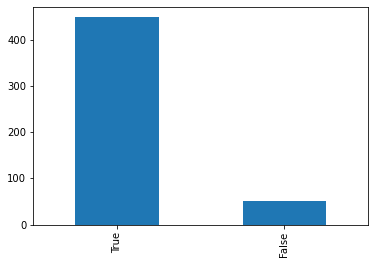

In [144]:
test_df.google_model_pass.value_counts().plot(kind='bar')